# Dynamic Time Warping for Speech Recognition
Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)

In [1]:
import os
from multiprocessing import Pool
import re
from tqdm import tqdm
from scipy.io import wavfile
from scipy.spatial.distance import cdist
import random
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
from IPython.display import Audio

## Data

The directory ```Data``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 ($F_e = 8000$ kHz). `SIG_Rep_5_Number_3.wav` is the recording corresponding to the fifth repetition of the number “3”.
- ```SIG2``` contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 (SIG_MIXED_Rep_7:12).

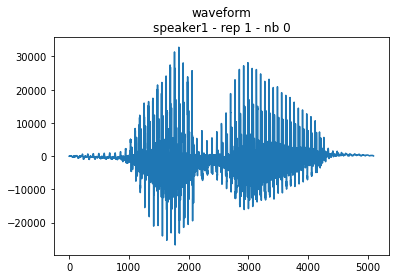

In [2]:
file_path = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.title("waveform\n" + "speaker1 - rep 1 - nb 0")
plt.show()

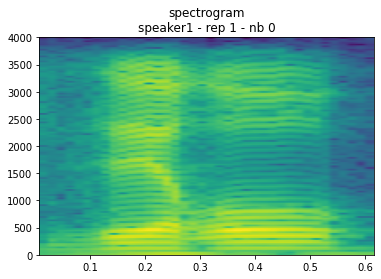

In [3]:
plt.specgram(wav_data, Fs=sample_rate)
plt.title("spectrogram\n" + "speaker1 - rep 1 - nb 0")
plt.show()

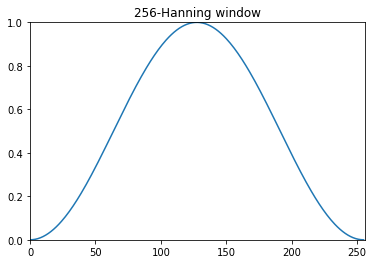

In [4]:
plt.plot(np.hanning(256))
plt.xlim(0, 256)
plt.ylim(0, 1)
plt.title("256-Hanning window")
plt.show()

## Speech Feature Extraction

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [5]:
def parse(wav_data, window_size, window_shift):
    """
    Computes the cepstral parameterization of a signal
    :param wav_data: numpy array representing the signal
    :param window_size: number of samples per frame
    :param window_shift: stride of the window
    :return: numpy array of shape (frame_number-1, window_size)
             each element is one slice of the signal
    """   
   
    frame_overlap = window_size - window_shift
    frame_number = wav_data.size // frame_overlap
    return np.array([wav_data[i*frame_overlap:i*frame_overlap + window_size] for i in range(frame_number-1)],
                    dtype=np.float64)

In [6]:
def feature_extraction(wav_data, window_size, window_shift, cepstral_order):
    """
    Parses the audio signal in frames of smaller duration with some overlap.
    The overlap is used because the Hann window makes the border values of the frames unusable,
    with overlapping they are not null in every frame.
    :param wav_data: numpy array representing the signal
    :param window_size: number of samples per frame
    :param window_shift: stride of the window
    :param cepstral_order: number of cepstral coefficients to keep
    :return: numpy array of shape (frame_number-1, p)
             cepstral coefficients
    """ 
    
    sliced_signal = parse(wav_data, window_size, window_shift)
    
    window = np.hanning(window_size)
    for signal_slice in sliced_signal:
        signal_slice *= window
    
    fft_norm = np.abs(np.fft.fft(sliced_signal))
    # no mel frequency filter bank mapping
    # we are using linear frequency scale
    log_fft_norm = np.log(fft_norm)
    
    # don't keep the first coefficient because it represents the signal amplitude
    # then cast to real
    cepstral_vectors = np.real(np.fft.ifft(log_fft_norm)[:, 1:cepstral_order+1])
    
    return cepstral_vectors

In [7]:
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [8]:
def plot_cepstral_coefs(cepstral_vectors, figsize=(10, 6)):
    """
    Plots the audio file's cepstral coefficients
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(cepstral_vectors.T, cmap=cm.coolwarm, origin='lower')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Cepstral coefficients')
    plt.xlabel('Frame #')
    plt.show()

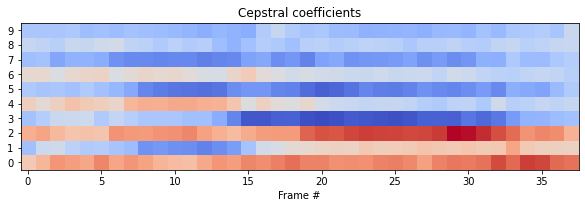

In [9]:
plot_cepstral_coefs(cepstral_vectors)

In [10]:
print(f"Shape of cepstral matrix: {cepstral_vectors.shape}")

Shape of cepstral matrix: (38, 10)


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $D (l_X \times l_Y)$ such that $D(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $C (l_X \times l_Y)$ such that $C(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $C(i,i)$ then $C(i+1,i), \dots C(l_X,i)$ and $C(i,i+1), C(i,i+2), \dots C(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```C```).

In [11]:
def local_opti(pred, pred_weight, C, D, i, j, gamma):
    """
    Computes the local optimum at (i, j) in the following box:
    -------------
    | i-1 | i-1 |
    | j-1 | j   |
    -------------
    | i   | i   |
    | j-1 | j   |
    -------------
    
    :param pred: predecessors array
    :param pred_weight: weights from the predecessors array
    :param C: cumulative distance matrix
    :param D: similarity matrix
    :param i: current abscissa
    :param j: current ordinate
    :param gamma: diagonal weighting
    :return: updated arrays pred, pred_weights, local optimal weight for the current point
    """
    
    weights = np.full((2, 2), np.inf)
    weights[1, 1] = C[i-1, j-1] + gamma*D[i, j] # travel down+right
    weights[0, 1] = C[i, j-1] + D[i, j]         # travel right
    weights[1, 0] = C[i-1, j] + D[i, j]         # travel down
    argmin = np.unravel_index(np.argmin(weights), weights.shape) # 2-tuple
    
    pred[i, j] = [i-argmin[0], j-argmin[1]]
    pred_weight[i, j] = gamma if argmin == (1, 1) else 1
    opti_weight = weights[argmin]
    
    return pred, pred_weight, opti_weight

In [12]:
def path_weights(pred, pred_weight, i, j):
    """
    Gives the weights on the optimal path
    Backtracking through the predecessors till reaching coords (0, 0)
        
    :param pred: predecessors array
    :param pred_weight: weights from the predecessors array
    :param i: abscissa of the departure point in the cumdist matrix
    :param j: ordinate of the departure point in the cumdist matrix
    :return: list of the weights on the optimal path
    """
    weights = []
    v = [i, j]
    
    while v[0] > 0 or v[1] > 0:
        weights.append(pred_weight[v[0], v[1]])
        v = pred[v[0], v[1]]
    
    return weights

In [13]:
def alignement_path(pred, length, i, j):
    """
    Computes the optimal alignment path
    
    :param pred: predecessors array
    :param length: length of the optimal path
    :param i: abscissa of the departure point in the cumdist matrix
    :param j: ordinate of the departure point in the cumdist matrix
    :return: array of shape (length+1, 2)
             1st column stores the selected indices of the 1st sequence
             2nd column stores the selected indices of the 2nd sequence
    """

    M = np.zeros((length+1, 2), dtype=int)
    v = [i, j]
    for i in range(1, length+1):
        M[length+1-i] = v
        v = pred[v[0], v[1]]
    M[0] = v
    
    return M

In [14]:
def time_alignment(x, y, gamma=1):
    """
    Performs Dynamic Time Warping on 2 sequences of vectors
        
    :param x: 1st sequence
    :param y: 2nd sequence
    :param gamma: diagonal weighting
    :return: cumulative distances matrix
             alignment path matrix matrix
             cumulative distance along the path of least cost
             length for the optimal path (weighted hops)
    """
    
    n, m = len(x), len(y)
    
    # to compute the global path at the end
    pred = np.zeros((n, m, 2), dtype=int)
    pred_weight = np.zeros((n, m), dtype=int)
    
    # compute the similarity (distance) matrix
    D = cdist(x, y)
    
    # compute the cumulative distance matrix
    C = np.zeros((n, m))
    
    ## 1st corner value
    C[0, 0] = D[0, 0]
    
    ## 1st row
    ## case i=0: predecessor can only be one column to the left
    for j in range(1, m):
        C[0, j] = C[0, j-1] + D[0, j]
        pred[0, j] = [0, j-1]
        pred_weight[0, j] = 1
    
    ## 1st column
    ## case j=0: predecessor can only be one line below
    for i in range(1, n):
        C[i, 0] = C[i-1, 0] + D[i, 0]
        pred[i, 0] = [i-1, 0]
        pred_weight[i, 0] = 1
        
    ## initialize the rest at infinite distance
    for i in range(1, n):
        for j in range(1, m):
            C[i, j] = np.inf
    
    ## complete the matrix
    for i in range(1, n):
        for j in range(1, m):
            pred, pred_weight, opti_weight = local_opti(pred, pred_weight, C, D, i, j, gamma)
            C[i, j] = opti_weight
    
    # compute the cumulative distance along the path of least cost
    optimal_weights = path_weights(pred, pred_weight, n-1, m-1) # start from the end
    nb_hops = len(optimal_weights)  # u+v (u hops of cost 1 + v hops of cost gamma)
    length = np.sum(optimal_weights) # u*1 + v*gamma
    M = alignement_path(pred, nb_hops, n-1, m-1)
    
    return C, M, C[-1, -1], length

In [15]:
file_path_1 = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./Data/SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(wav_data_2, window_size, window_shift, cepstral_order)

C, M, distance, length = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

In [16]:
def print_path(C, M, distance, length, figsize=(6, 6)):
    """
    Prints the path of the DTW algorithm on a 2D graph
    
    :param C: cumulative distance matrix
    :param M: alignment path matrix
    :param distance: cumulative distance along the path of least cost
    :length: length for the optimal path (weighted hops)
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(C, cmap="jet") # plot the background: cumdist matrix
    plt.plot(M[:, 1], M[:, 0], 'k', linewidth=2) # plot the path
    plt.show()
    
    print(f"Optimal path normalized distance: {distance/length:.4g}")

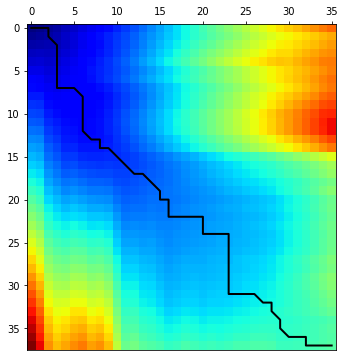

Optimal path normalized distance: 0.2295


In [17]:
print_path(C, M, distance, length)

## Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory?
2. What is the influence of the choice of γ (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them)? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

In [18]:
n_reps = 12
file_path = "./Data/SIG/"

In [70]:
def load_numbers(file_path, n_reps):
    """
    Loads the .wav files in memory
    """
    numbers = [[np.empty(0) for n in range(10)] for rep in range(n_reps+1)]
    for filename in os.listdir(file_path):
        res = re.search(r"SIG.*_Rep_(\d+)_Number_(\d+).wav", filename)
        sample_rate, wav_data = wavfile.read(file_path + res.group(0))
        numbers[int(res.group(1))][int(res.group(2))] = wav_data
    return numbers

In [20]:
%%time
numbers = load_numbers(file_path, n_reps)

CPU times: user 29.9 ms, sys: 58 ms, total: 87.9 ms
Wall time: 40.1 ms


**Usage:** `numbers[repetition][digit]`, `repetition` in $[1, 12]$, `digit` in $[0, 9]$

In [21]:
def compute_cc(numbers, n_reps):
    """
    Computes the cepstral coefficients for all the numbers
    """
    cc = [[np.empty(0) for n in range(10)] for rep in range(n_reps+1)]
    for rep in range(1, n_reps+1):
        for digit in range(10):
            cc[rep][digit] = feature_extraction(numbers[rep][digit], window_size, window_shift, cepstral_order)
    return cc

In [22]:
%%time
cc = compute_cc(numbers, n_reps)

CPU times: user 57.9 ms, sys: 1.33 ms, total: 59.3 ms
Wall time: 58.2 ms


**Usage:** `cc[repetition][digit]`, `repetition` in $[1, 12]$, `digit` in $[0, 9]$

In [23]:
def compute_norm_dists(cc, gamma, n_reps):
    """
    Computes the normalized distances between
    the different digits from the different repetitions
    """
    norm_dists = np.full((n_reps+1, 10, n_reps+1, 10), np.inf)

    for rep1 in range(1, n_reps+1):
        for digit1 in range(10):
            for rep2 in range(rep1, n_reps+1):
                for digit2 in range(10):
                    C, M, distance, length = time_alignment(cc[rep1][digit1], cc[rep2][digit2], gamma)
                    norm_dists[rep1][digit1][rep2][digit2] = distance/length
    return norm_dists

In [24]:
%%time
norm_dists = compute_norm_dists(cc, 2, n_reps)

CPU times: user 1min 34s, sys: 130 ms, total: 1min 34s
Wall time: 1min 34s


**Usage:** `norm_dists[rep1][digit1][rep2][digit2]`

Normalized distance between `digit1` from `rep1` and `digit2` from `rep2` where `rep1` $\le$ `rep2`

In [25]:
def compute_confusion_matrix(norm_dists, n_reps):
    """
    Computes the confusion matrix from the normalized distances
    """
    conf_mat = np.zeros((10, 10))

    for reference_rep in range(1, n_reps+1):
        for other_rep in range(reference_rep+1, n_reps+1): # iterate on the other repetitions
            for ref_digit in range(10):                    # iterate on all the digits
                # get the normalized distances to the reference digit
                # for all digits in the current repetition
                digits_dists = norm_dists[reference_rep][ref_digit][other_rep][:]
                # estimate the closest digit
                est_digit = np.argmin(digits_dists)
                # add this estimate in the confusion matrix
                conf_mat[ref_digit][est_digit] += 1
    
    return conf_mat

In [26]:
%%time
confusion_matrix = compute_confusion_matrix(norm_dists, n_reps)

CPU times: user 79 µs, sys: 4.01 ms, total: 4.09 ms
Wall time: 3 ms


In [27]:
def plot_conf_mat(confusion_matrix):
    """
    Plots the confusion matrix
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confusion_matrix, cmap='Greys')
    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, f'{int(z)}', ha='center', va='center', color='w')
    ax.set_xlabel("estimated digit")
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel("reference digit")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

<hr>

**1.**

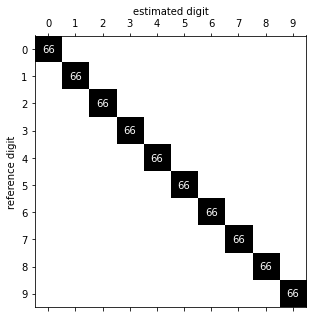

In [28]:
plot_conf_mat(confusion_matrix)

This is a perfect score!

Let's now try $\gamma = 1$ i.e. no diagonal penalty.

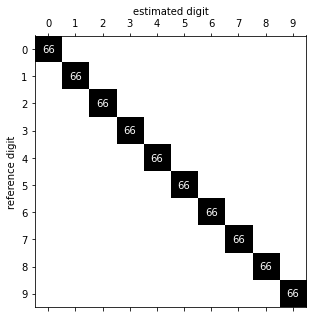

In [29]:
norm_dists = compute_norm_dists(cc, 1, n_reps)
confusion_matrix = compute_confusion_matrix(norm_dists, n_reps)
plot_conf_mat(confusion_matrix)

No change in performance.

What about $\gamma = 3$?

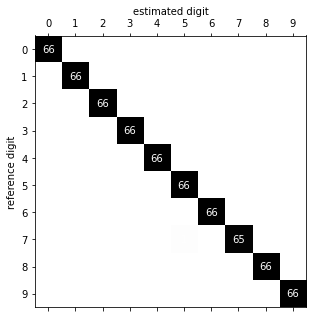

In [30]:
norm_dists = compute_norm_dists(cc, 3, n_reps)
confusion_matrix = compute_confusion_matrix(norm_dists, n_reps)
plot_conf_mat(confusion_matrix)

Still a perfect score.

All in all, the speech recognition performance is very good (although there is only 1 speaker considered).

<hr>

**2.**

Comparison of the paths for two '5' digits

- $\gamma = 1$

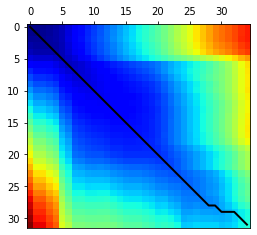

Optimal path normalized distance: 0.2695


In [31]:
C, M, distance, length = time_alignment(cc[3][5], cc[8][5], 1)
print_path(C, M, distance, length, figsize=(4, 4))

- $\gamma = 2$

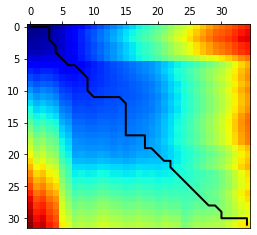

Optimal path normalized distance: 0.2408


In [32]:
C, M, distance, length = time_alignment(cc[3][5], cc[8][5], 2)
print_path(C, M, distance, length, figsize=(4, 4))

- $\gamma = 3$

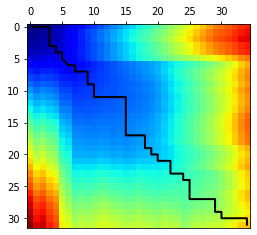

Optimal path normalized distance: 0.2475


In [33]:
C, M, distance, length = time_alignment(cc[3][5], cc[8][5], 3)
print_path(C, M, distance, length, figsize=(4, 4))

It is no surprise that the shape of the paths go from _diagonal_-like to _staircase_-like when $\gamma$ increases, since the diagonal hops are less and less locally favoured.

However, the normalized distance of the path does not evolve that much.

<hr>

**3.**

For each time frame, the vector of spectral coefficients is in $\mathbb{R}^p$ and the frame-to-frame distance computation in the DTW algorithm uses the $L^2$ norm (Euclidean distance): we have implicitly considered that all cepstrum coefficients are equally important. This has no reason to be the case.

We could therefore apply a weighting to these coefficients beforehand, with the first coefficients weighting more than the last ones (we already kept only 10 coefficients here).

In the calculation of the MFCCs, a lifetering is usually applied on the resulting vector (liftering because filtering of a quefrency).

Without intensive testing, we cannot say what kind of weighting (exponential decrease, 1/n decrease...) it would be smart to use but the discrimination performance could certainly be improved a little this way.

In [34]:
def liftering(cc):    
    N = len(cc)
    n = np.arange(N) +1
    liftering = 1 + (N / 2) * np.sin(np.pi * n / N)    
    cc *= liftering
    
    return cc

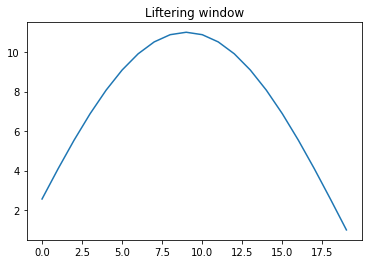

In [47]:
N = 20
n = np.arange(N) +1
liftering = 1 + (N / 2) * np.sin(np.pi * n / N) 

plt.plot(liftering)
plt.title("Liftering window")
plt.show()

## Evaluation of Speech Recognition

The goal of this part is to implement different cross-validation strategies in order to evaluate how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *reference* and *unknown* set, and label all the unknown signals by finding the signal in the reference set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. We will then rotate the reference/unknown sets to perform cross-validation. 
To do so, write a function ```evaluation_recognition```.

For example, you can use the following formalism : 

```confusion, accuracy, D = evaluation_recognition(vectors, gamma, protocol)```

- ```vectors``` contains all the cepstral vectors for the signals in the database. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.
- ```protocol``` is an integer value between 1 and 3 indicating the protocol to be used: each protocol corresponds to a particular way of dividing signals into training and testing sets. 

- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate.
- ```D``` is the distance matrix between each of the elements of the database of size $10N \times 10N$, where $N$ is the number of repetitions. Note that only parts of ```D``` will be used, depending on the protocol choosed. 

The three proposed evaluation protocols are:
- **Protocol 1**: The database is randomly divided in three subsets. Two of these subsets (2/3 of repetitions) are used for the reference set and the remaining subset (1/3 of repetitions) is used for the unknown set. The procedure is repeated by rotating the unknown and reference sets.
- **Protocol 2**: A database containing only one pronunciation of each number is used as a reference database. The remaining repetitions are used for the unknown set. The procedure is repeated by rotating the unkown and reference sets. This protocol aims at evaluating the generalization capabilities of the recognition system. 
- **Protocol 3**: The first half of the database of ```SIG_MIXED``` is used as a reference database and the second half as the unkown database. The procedure is repeated by inversing the role of the two sets. This protocol aims at evaluating the generalization capabilities on a database containing data from the two speakers. Careful: since the goal here is to understand if you can use examples from one person to recognize numbers pronounced by a different person, you must not shuffle the examples!

Questions: 
- Evaluate the speech recognition performance with protocol 1 on the data ```SIG```, and then on the data ```SIG2```. What are the confusions? What value of $\gamma$ parameter offers the best results?
- Evaluate the generalization capabilities using protocol 2 on the data ```SIG```, and then on the data ```SIG2```. What do you notice?
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Explain the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab? Propose possible solutions to these problems.

In [48]:
def protocol1_worker(i, unknown_reps, unknown_digits,
                     ref_reps_a, ref_digits_a, ref_reps_b, ref_digits_b,
                     vectors, norm_dists, gamma):
    unknown_rep = unknown_reps[i]
    unknown_digit = unknown_digits[i]
    ret = []
    
    # compute for the reference category a
    for (j, ref_rep_a) in enumerate(ref_reps_a):
        ref_digit_a = ref_digits_a[j]
        C, M, distance, length = time_alignment(vectors[unknown_rep][unknown_digit],
                                                vectors[ref_rep_a][ref_digit_a],
                                                gamma)
        ret.append(distance/length)
    
    # compute for the reference category b
    for (k, ref_rep_b) in enumerate(ref_reps_b):
        ref_digit_b = ref_digits_b[k]
        C, M, distance, length = time_alignment(vectors[unknown_rep][unknown_digit],
                                                vectors[ref_rep_a][ref_digit_a],
                                                gamma)
        ret.append(distance/length)
        
    return ret

In [49]:
def protocol2_worker(ref_rep, unknown_rep, unknown_digit, vectors, norm_dists, gamma):
    ret = []
    
    for ref_digit in range(10):
        C, M, distance, length = time_alignment(vectors[unknown_rep][unknown_digit],
                                                vectors[ref_rep][ref_digit],
                                                gamma)
        ret.append(distance/length)
    
    return ret

In [101]:
def protocol3_worker(i, ref_reps, ref_digits, unknown_reps, unknown_digits, vectors, norm_dists, gamma):
    
    unknown_rep = unknown_reps[i]
    unknown_digit = unknown_digits[i]
    ret = []
    
    # compute for the reference category a
    for (j, ref_rep) in enumerate(ref_reps):
        ref_digit = ref_digits[j]
        C, M, distance, length = time_alignment(vectors[unknown_rep][unknown_digit],
                                                vectors[ref_rep][ref_digit],
                                                gamma)
        ret.append(distance/length)
    
    return ret
    

ERROR! Session/line number was not unique in database. History logging moved to new session 94


In [112]:
def evaluation_recognition(vectors, gamma, protocol):
    """
    Performs cross-validation on a speech recognition task
    
    :param vectors: contains all the cepstral vectors for the signals
    :param gamma: the diagonal parameter of the alignment
    :param protocol: int in (1, 2, 3) defining the protocol of the cross-validation
    :return: confusion matrix, array of shape (10, 10)
             accuracy (recognition rate)
             distance matrix between each element in the database
    """
    
    # initialize the confusion matrix
    # row: reference digit
    # column: estimated digit
    conf_mat = np.zeros((10, 10))
    
    if protocol not in [1, 2, 3]:
        raise ValueError("Protocol must be 1, 2 or 3")

    ## protocol 1 ##
    if protocol == 1:
        
        # number of repetitions in the database
        n_reps = len(vectors) - 1

        # generate indices for the categories
        indices = np.arange(10, (n_reps+1)*10)
        np.random.shuffle(indices)
        cat1, cat2, cat3 = np.array_split(indices, 3)
        
        # mask for the reference digits
        # 1st row is unused for interoperability
        mask = np.full((n_reps+1, 10), -1)
        for idx in cat1:
            mask[idx // 10][idx % 10] = 1
        for idx in cat2:
            mask[idx // 10][idx % 10] = 2
        for idx in cat3:
            mask[idx // 10][idx % 10] = 3
            
        # normalized distances matrix
        norm_dists = np.full((n_reps+1, 10, n_reps+1, 10), np.inf)
        
        # instantiate the multiprocess pool
        if __name__ == '__main__':
            p = Pool(processes=4)
        # rotate over the categories for the unknown set
        for unknown in [1, 2, 3]:
            print(f"Protocol 1: doing fold #{unknown}")
            
            # known categories
            ref = [_ for _ in [1, 2, 3] if _ != unknown]
            
            # arrays of unknown repetitions, unknown digits respectively
            unknown_reps, unknown_digits = np.where(mask == unknown)
            # arrays of reference repetitions, reference digits respectively
            ref_reps_a, ref_digits_a = np.where(mask == ref[0]) # 2nd third of the dataset
            ref_reps_b, ref_digits_b = np.where(mask == ref[1]) # 3rd third of the dataset
            
            # fill in the distance matrix
            n = len(unknown_reps) # = len(unknown_digits)
            to_process = []
            for i in range(n):
                to_process.append((i, unknown_reps, unknown_digits,
                                   ref_reps_a, ref_digits_a, ref_reps_b, ref_digits_b,
                                   vectors, norm_dists, gamma))
            
            pool_output = p.starmap(protocol1_worker, to_process)
            
            for i in range(n):
                unknown_rep = unknown_reps[i]
                unknown_digit = unknown_digits[i]
                ret = pool_output[i]
                # reference category a
                for (j, ref_rep_a) in enumerate(ref_reps_a):
                    ref_digit_a = ref_digits_a[j]
                    norm_dists[unknown_rep][unknown_digit][ref_rep_a][ref_digit_a] = ret.pop(0)
                # reference category b
                for (k, ref_rep_b) in enumerate(ref_reps_b):
                    ref_digit_b = ref_digits_b[j]
                    norm_dists[unknown_rep][unknown_digit][ref_rep_a][ref_digit_a] = ret.pop(0)
            
            # estimate the digits for this category
            for (i, unknown_rep) in enumerate(unknown_reps):
                unknown_digit = unknown_digits[i]
                
                # normalized distance matrix for this digit
                dmat = norm_dists[unknown_rep][unknown_digit][:][:]
                
                # take the argmin and throw away the repetition for the best match
                _, estimated_digit = np.unravel_index(np.argmin(dmat), dmat.shape)
                
                # add this into the confusion matrix
                conf_mat[unknown_digit][estimated_digit] += 1
        
        # gracefully close the pool
        p.close()
        p.join()
        
        # compute accuracy
        accuracy = np.sum(np.diag(conf_mat)) / np.sum(conf_mat)
        
        return conf_mat, accuracy, norm_dists
    
    
    ## protocol 2 ##
    if protocol == 2:
        
        # number of repetitions in the database
        n_reps = len(vectors) - 1
        
        # normalized distances matrix
        norm_dists = np.full((n_reps+1, 10, n_reps+1, 10), np.inf)
        
        # instantiate the multiprocess pool
        if __name__ == '__main__':
            p = Pool(processes=6)
            
        # rotate over the categories for the reference set
        for ref_rep in range(1, n_reps+1):
            print(f"Protocol 2: doing fold {ref_rep}/{n_reps}")
            
            # fill in the distance matrix
            unknown_reps = [_ for _ in range(1, n_reps+1) if _ != ref_rep]
            unknown_digits = [_ for _ in range(10)]
            to_process = []
            for unknown_rep in unknown_reps:
                for unknown_digit in unknown_digits:
                    to_process.append((ref_rep, unknown_rep, unknown_digit, vectors, norm_dists, gamma))
            
            pool_output = p.starmap(protocol2_worker, to_process)
            
            for unknown_rep in unknown_reps:
                for unknown_digit in unknown_digits:
                    dist10 = pool_output.pop(0)
                    for ref_digit in range(10):
                        norm_dists[unknown_rep][unknown_digit][ref_rep][ref_digit] = dist10.pop(0)
            
            # estimate the digits for this reference category
            for unknown_rep in unknown_reps:
                for unknown_digit in unknown_digits:
                    # normalized distance matrix for this digit
                    dmat = norm_dists[unknown_rep][unknown_digit][ref_rep][:]

                    # take the argmin and throw away the repetition for the best match
                    estimated_digit = np.argmin(dmat)

                    # add this into the confusion matrix
                    conf_mat[unknown_digit][estimated_digit] += 1
                    
        # gracefully close the pool
        p.close()
        p.join()
        
        # compute accuracy
        accuracy = np.sum(np.diag(conf_mat)) / np.sum(conf_mat)
        
        return conf_mat, accuracy, norm_dists
                        
    
    ## protocol 3 ##
    if protocol == 3:
        
        # number of repetitions in the database
        n_reps = len(vectors) - 1        
        
        indices = np.arange(10, (n_reps+1)*10)
        ref, unkn = np.array_split(indices, 2)
                
        # mask for the reference digits
        # 1st row is unused for interoperability
        mask = np.full((n_reps+1, 10), -1)
        for idx in ref:
            mask[idx // 10][idx % 10] = 1
        for idx in unkn:
            mask[idx // 10][idx % 10] = 2
            
        # normalized distances matrix
        norm_dists = np.full((n_reps+1, 10, n_reps+1, 10), np.inf)
        
        # instantiate the multiprocess pool
        if __name__ == '__main__':
            p = Pool(processes=2)
        # One half is ref set, the other half is unknown. Then invert.
        for unknown in [1, 2]:
            print(f"Protocol 3: unknwon fold  = #{unknown} Half")
            
        
           # known categories
            ref = [_ for _ in [1, 2] if _ != unknown]
            
            # arrays of unknown repetitions, unknown digits respectively
            unknown_reps, unknown_digits = np.where(mask == unknown)
            
            # arrays of reference repetitions, reference digits respectively
            ref_reps, ref_digits = np.where(mask == ref[0]) # 2nd half of the dataset
            
            # fill in the distance matrix
            n = len(unknown_reps) # = len(unknown_digits)
            to_process = []
            for i in range(n):
                to_process.append((i, unknown_reps, unknown_digits,ref_reps, 
                                   ref_digits, vectors, norm_dists, gamma))
            
            pool_output = p.starmap(protocol3_worker, to_process)
            
            for i in range(n):
                unknown_rep = unknown_reps[i]
                unknown_digit = unknown_digits[i]
                ret = pool_output[i]
                # reference category :
                for (j, ref_rep) in enumerate(ref_reps):
                    ref_digit = ref_digits[j]
                    norm_dists[unknown_rep][unknown_digit][ref_rep][ref_digit] = ret.pop(0)
                
            
            # estimate the digits for this category
            for (i, unknown_rep) in enumerate(unknown_reps):
                unknown_digit = unknown_digits[i]
                
                # normalized distance matrix for this digit
                dmat = norm_dists[unknown_rep][unknown_digit][:][:]
                
                # take the argmin and throw away the repetition for the best match
                _, estimated_digit = np.unravel_index(np.argmin(dmat), dmat.shape)
                
                # add this into the confusion matrix
                conf_mat[unknown_digit][estimated_digit] += 1
        
        # gracefully close the pool
        p.close()
        p.join()
        
        # compute accuracy
        accuracy = np.sum(np.diag(conf_mat)) / np.sum(conf_mat)
        
        return conf_mat, accuracy, norm_dists

<hr>

**Protocol 1**

In [113]:
file_path_SIG = "./Data/SIG/"
n_reps_SIG = 12
numbers_SIG = load_numbers(file_path_SIG, n_reps_SIG)
vectors_SIG = compute_cc(numbers_SIG, n_reps_SIG)
confusion_SIG, accuracy_SIG, D_SIG = evaluation_recognition(vectors_SIG, 2, 1)
print(f"Accuracy on SIG data: {accuracy_SIG:.2f}")

Protocol 1: doing fold #1
Protocol 1: doing fold #2
Protocol 1: doing fold #3
Accuracy on SIG data: 1.00


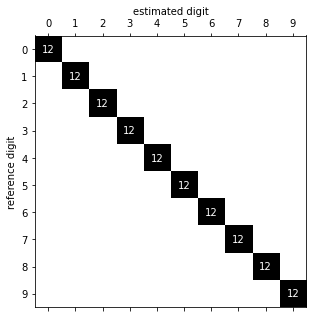

In [114]:
plot_conf_mat(confusion_SIG)

In [124]:
file_path_SIG2 = "./Data/SIG2/"
n_reps_SIG2 = 6
numbers_SIG2 = load_numbers(file_path_SIG2, n_reps_SIG2)
vectors_SIG2 = compute_cc(numbers_SIG2, n_reps_SIG2)
confusion_SIG2, accuracy_SIG2, D_SIG2 = evaluation_recognition(vectors_SIG2, 2, 1)
print(f"Accuracy on SIG2 data: {accuracy_SIG2:.2f}")

Protocol 1: doing fold #1
Protocol 1: doing fold #2
Protocol 1: doing fold #3
Accuracy on SIG2 data: 1.00


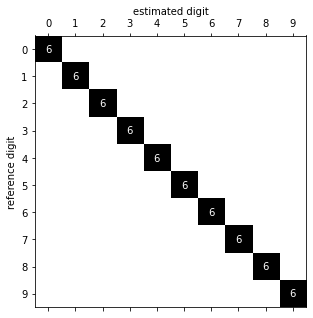

In [125]:
plot_conf_mat(confusion_SIG2)

<hr>

**Protocol 2**

In [117]:
confusion_SIG, accuracy_SIG, D_SIG = evaluation_recognition(vectors_SIG, 2, 2)
print(f"Accuracy on SIG data: {accuracy_SIG:.2f}")

Protocol 2: doing fold 1/12
Protocol 2: doing fold 2/12
Protocol 2: doing fold 3/12
Protocol 2: doing fold 4/12
Protocol 2: doing fold 5/12
Protocol 2: doing fold 6/12
Protocol 2: doing fold 7/12
Protocol 2: doing fold 8/12
Protocol 2: doing fold 9/12
Protocol 2: doing fold 10/12
Protocol 2: doing fold 11/12
Protocol 2: doing fold 12/12
Accuracy on SIG data: 1.00


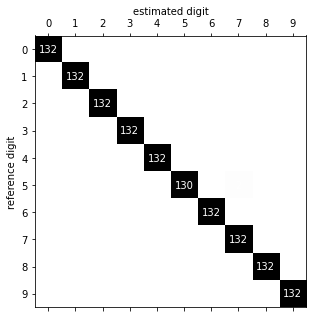

In [118]:
plot_conf_mat(confusion_SIG)

In [119]:
confusion_SIG2, accuracy_SIG2, D_SIG2 = evaluation_recognition(vectors_SIG2, 2, 2)
print(f"Accuracy on SIG2 data: {accuracy_SIG2:.2f}")

Protocol 2: doing fold 1/6
Protocol 2: doing fold 2/6
Protocol 2: doing fold 3/6
Protocol 2: doing fold 4/6
Protocol 2: doing fold 5/6
Protocol 2: doing fold 6/6
Accuracy on SIG2 data: 1.00


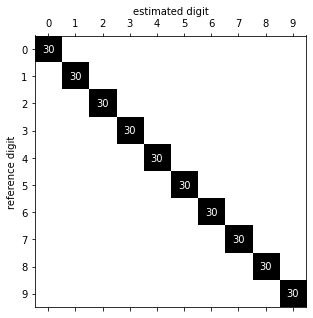

In [120]:
plot_conf_mat(confusion_SIG2)

<hr>

**Protocol 3**

In [121]:
def load_numbers_MIX(file_path, n_reps):
    """
    Loads the .wav files in memory
    """
    numbers = [[np.empty(0) for n in range(10)] for rep in range(n_reps+1)]
    for filename in os.listdir(file_path):
        res = re.search(r"SIGMIX.*_Rep_(\d+)_Number_(\d+).wav", filename)
        sample_rate, wav_data = wavfile.read(file_path + res.group(0))
        numbers[int(res.group(1))][int(res.group(2))] = wav_data
    return numbers

In [122]:
file_path_SIG3 = "./Data/SIGMIX/"
n_reps_SIG3 = 12
numbers_SIG3 = load_numbers_MIX(file_path_SIG3, n_reps_SIG3)
vectors_SIG3 = compute_cc(numbers_SIG3, n_reps_SIG3)


Protocol 3: unknwon fold  = #1 Half
Protocol 3: unknwon fold  = #2 Half
Accuracy on SIGMIX data: 1.00


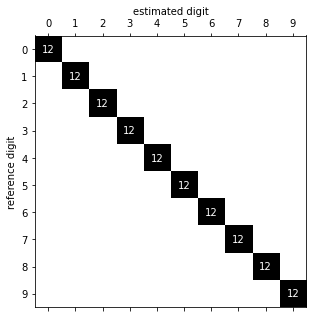

In [123]:
confusion_SIG3, accuracy_SIG3, D_SIG3 = evaluation_recognition(vectors_SIG, 2, 3)
print(f"Accuracy on SIGMIX data: {accuracy_SIG3:.2f}")
plot_conf_mat(confusion_SIG3)